<a href="https://colab.research.google.com/github/anahita-najafi/NeuroMatchAcademy-DLcourse2022/blob/main/NLP/Copy_of_W2D5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Introduction to processing time series

**Week 2, Day 5: Time Series And Natural Language Processing**

**By Neuromatch Academy**

__Content creators:__ Lyle Ungar, Kelson Shilling-Scrivo, Alish Dipani

__Content reviewers:__ Kelson Shilling-Scrivo

__Content editors:__ Gagana B, Spiros Chavlis, Kelson Shilling-Scrivo

__Production editors:__ Gagana B, Spiros Chavlis

<br>

_Based on Content from: Anushree Hede, Pooja Consul, Ann-Katrin Reuel_

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

----
# Tutorial objectives

Before we begin exploring how Recurrent Neural Networks (RNNs) excel at modeling sequences, we will explore other ways we can model sequences, encode text, and make meaningful measurements using such encodings and embeddings.

In [ ]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src="https://mfr.ca-1.osf.io/render?url=https://osf.io/n263c/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for the videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/n263c/download).

---
# Setup

In [ ]:
# @title Install dependencies

# @markdown There may be *errors* and/or *warnings* reported during the installation. However, they are to be ignored.
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html --quiet
!pip install --upgrade gensim --quiet
!pip install nltk --quiet
!pip install python-Levenshtein --quiet
!pip install git+https://github.com/facebookresearch/fastText.git --quiet

!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet

from evaltools.airtable import AirtableForm
atform = AirtableForm('appn7VdPRseSoMXEG', 'W2D5_T1', 'https://portal.neuromatchacademy.org/api/redirect/to/9c55f6cb-cdf9-4429-ac1c-ec44fe64c303')

     |█████████████▌                  | 834.1 MB 1.3 MB/s eta 0:14:20tcmalloc: large alloc 1147494400 bytes == 0x39af6000 @  0x7f435abd6615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████               | 1055.7 MB 1.3 MB/s eta 0:12:06tcmalloc: large alloc 1434370048 bytes == 0x7e14c000 @  0x7f435abd6615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████▋          | 1336.2 MB 1.2 MB/s eta 0:08:43tcmalloc: large alloc 1792966656 bytes == 0x2f7e000 @  0x7f435abd6615 0x592b76 0x4df71e 0x59afff 0x515655 0x5

In [ ]:
# Imports
import time
import nltk
import fasttext

import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

import torch.nn as nn
from torch.nn import functional as F

from torchtext.legacy import data, datasets
from torchtext.vocab import FastText

In [ ]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [ ]:
# @title  Load Dataset from `nltk`
# No critical warnings, so we suppress it
import warnings
warnings.simplefilter("ignore")

nltk.download('punkt')
nltk.download('brown')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [ ]:
# @title Helper functions
import requests


def download_file_from_google_drive(id, destination):
  URL = "https://docs.google.com/uc?export=download"
  session = requests.Session()
  response = session.get(URL, params={'id': id}, stream=True)
  token = get_confirm_token(response)

  if token:
    params = {'id': id, 'confirm': token}
    response = session.get(URL, params=params, stream=True)

  save_response_content(response, destination)


def get_confirm_token(response):
  for key, value in response.cookies.items():
    if key.startswith('download_warning'):
      return value

  return None


def save_response_content(response, destination):
  CHUNK_SIZE = 32768
  with open(destination, "wb") as f:
    for chunk in response.iter_content(CHUNK_SIZE):
      if chunk:  # filter out keep-alive new chunks
        f.write(chunk)

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)

GPU is enabled in this notebook.
Random seed 2021 has been set.


---
# Section 1: Intro: What time series are there?

*Time estimate: 20 mins*

In [ ]:
# @title Video 1: Time Series and NLP
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="W4RTRXt7pO0", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 1: Time Series and NLP')

display(out)

In [ ]:
# @title Video 2: What is NLP?
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="Q-PGZyaBQVk", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 2: What is NLP')

display(out)

---
# Section 2: Embeddings

*Time estimate: 50 mins*

In [ ]:
# @title Video 3: Embeddings Rule!
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="7ijjjFpcOwI", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 3: Embeddings Rule!')

display(out)

## Section 2.1: Introduction

[Word2vec](https://rare-technologies.com/word2vec-tutorial/) is a group of related models used to produce word embeddings. These models are shallow, two-layer neural networks trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, with each unique word in the corpus being assigned a corresponding vector in the space.

### Creating Word Embeddings

We will create embeddings for a subset of categories in [Brown corpus](https://www1.essex.ac.uk/linguistics/external/clmt/w3c/corpus_ling/content/corpora/list/private/brown/brown.html). To achieve this task we will use [gensim](https://radimrehurek.com/gensim/) library to create word2vec embeddings. Gensim’s word2vec expects a sequence of sentences as its input. Each sentence is a list of words.

Calling Word2Vec(sentences, `iter=1`) will run two passes over the sentences iterator (generally, `iter+1` passes). The first pass collects words and their frequencies to build an internal dictionary tree structure. The second and subsequent passes train the neural model. 
Word2vec accepts several parameters that affect both training speed and quality.

One of them is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there are not enough data to make any meaningful training on those words, so it’s best to ignore them:

```python
model = Word2Vec(sentences, min_count=10)  # default value is 5
```

A reasonable value for `min_count` is bewteen 0-100, depending on the size of your dataset.

Another parameter is the `size` of the NN layers, which correspond to the “degrees” of freedom the training algorithm has:

```python
model = Word2Vec(sentences, size=200)  # default value is 100
```

Bigger `size` values require more training data but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.

The last of the major parameters (full list [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)) is for training parallelization, to speed up training:

```python
model = Word2Vec(sentences, workers=4)  # default = 1 worker = no parallelization
```

In [ ]:
# Categories used for the Brown corpus
category = ['editorial', 'fiction', 'government', 'mystery', 'news', 'religion',
            'reviews', 'romance', 'science_fiction']

In [ ]:
# @markdown Word2Vec model

def create_word2vec_model(category='news', size=50, sg=1, min_count=5):
  sentences = brown.sents(categories=category)
  model = Word2Vec(sentences, vector_size=size,
                   sg=sg, min_count=min_count)
  return model


def model_dictionary(model):
  print(w2vmodel.wv)
  words = list(w2vmodel.wv)
  return words


def get_embedding(word, model):
  if word in w2vmodel.wv:
    return model.wv[word]
  else:
    return None

The cell will take 30-45 seconds to run.

In [ ]:
# Create a word2vec model based on categories from Brown corpus
w2vmodel = create_word2vec_model(category)

You can get the embedding vector for a word in the dictionary.

In [ ]:
# get word list from Brown corpus
brown_wordlist = list(brown.words(categories=category))
# generate a random word
random_word = random.sample(brown_wordlist, 1)[0]
# get embedding of the random word
random_word_embedding = get_embedding(random_word, w2vmodel)
print(f'Embedding of "{random_word}" is {random_word_embedding}')

Embedding of "company" is [ 0.24052879 -0.1401168  -0.0183609   0.148802   -0.24917133  0.16152802
  0.30139703  0.06792106  0.08685599 -0.01544173  0.13948207  0.13160911
  0.13136472  0.01767075 -0.32585362  0.10396535  0.31209475  0.01759592
  0.02813846 -0.16513419  0.24772735 -0.12682189  0.21378191 -0.1291364
 -0.02366635  0.2700977  -0.3168694   0.04020232 -0.26055205  0.00414423
  0.1860369  -0.05476782  0.54025227 -0.00765974  0.01897902 -0.03972004
  0.37707752  0.24123082  0.33798367 -0.37927875  0.1861444   0.10382404
 -0.44637483 -0.05602334  0.45430398  0.00622217  0.16542438 -0.15762514
  0.20348515  0.37592494]


### Visualizing Word Embeddings

We can now obtain the word embeddings for any word in the dictionary using word2vec. Let's visualize these embeddings to get an intuition of what these embeddings mean. The word embeddings obtained from the word2vec model are in high dimensional space, and we will use tSNE to pick the two features that capture the most variance in the embeddings to represent them in a 2D space.

For each word in `keys`, we pick the top 10 similar words (using cosine similarity) and plot them.

Before you run the code, spend some time to think:

- What should be the arrangement of similar words?
- What should be the arrangement of the critical clusters with respect to each other?

In [ ]:
keys = ['voters', 'magic', 'love', 'God', 'evidence', 'administration', 'governments']

In [ ]:
# @markdown ### Cluster embeddings related functions

# @markdown **Note:** We import [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def get_cluster_embeddings(keys):
  embedding_clusters = []
  word_clusters = []

  # find closest words and add them to cluster
  for word in keys:
    embeddings = []
    words = []
    if not word in w2vmodel.wv:
      print(f'The word {word} is not in the dictionary')
      continue

    for similar_word, _ in w2vmodel.wv.most_similar(word, topn=10):
      words.append(similar_word)
      embeddings.append(w2vmodel.wv[similar_word])
    embeddings.append(get_embedding(word, w2vmodel))
    words.append(word)
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

  # get embeddings for the words in clusers
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
  return embeddings_en_2d, word_clusters


def tsne_plot_similar_words(title, labels, embedding_clusters,
                            word_clusters, opacity, filename=None):
  plt.figure(figsize=(16, 9))
  colors = cm.rainbow(np.linspace(0, 1, len(labels)))
  for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    plt.scatter(x, y, color=color, alpha=opacity, label=label)
    # Plot the cluster centroids
    plt.plot(np.mean(x), np.mean(y), 'x', color=color, markersize=16)
    for i, word in enumerate(words):
      size = 10 if i < 10 else 14
      plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                    textcoords='offset points',
                    ha='right', va='bottom', size=size)
  plt.legend()
  plt.title(title)
  plt.grid(True)
  if filename:
    plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
  plt.show()

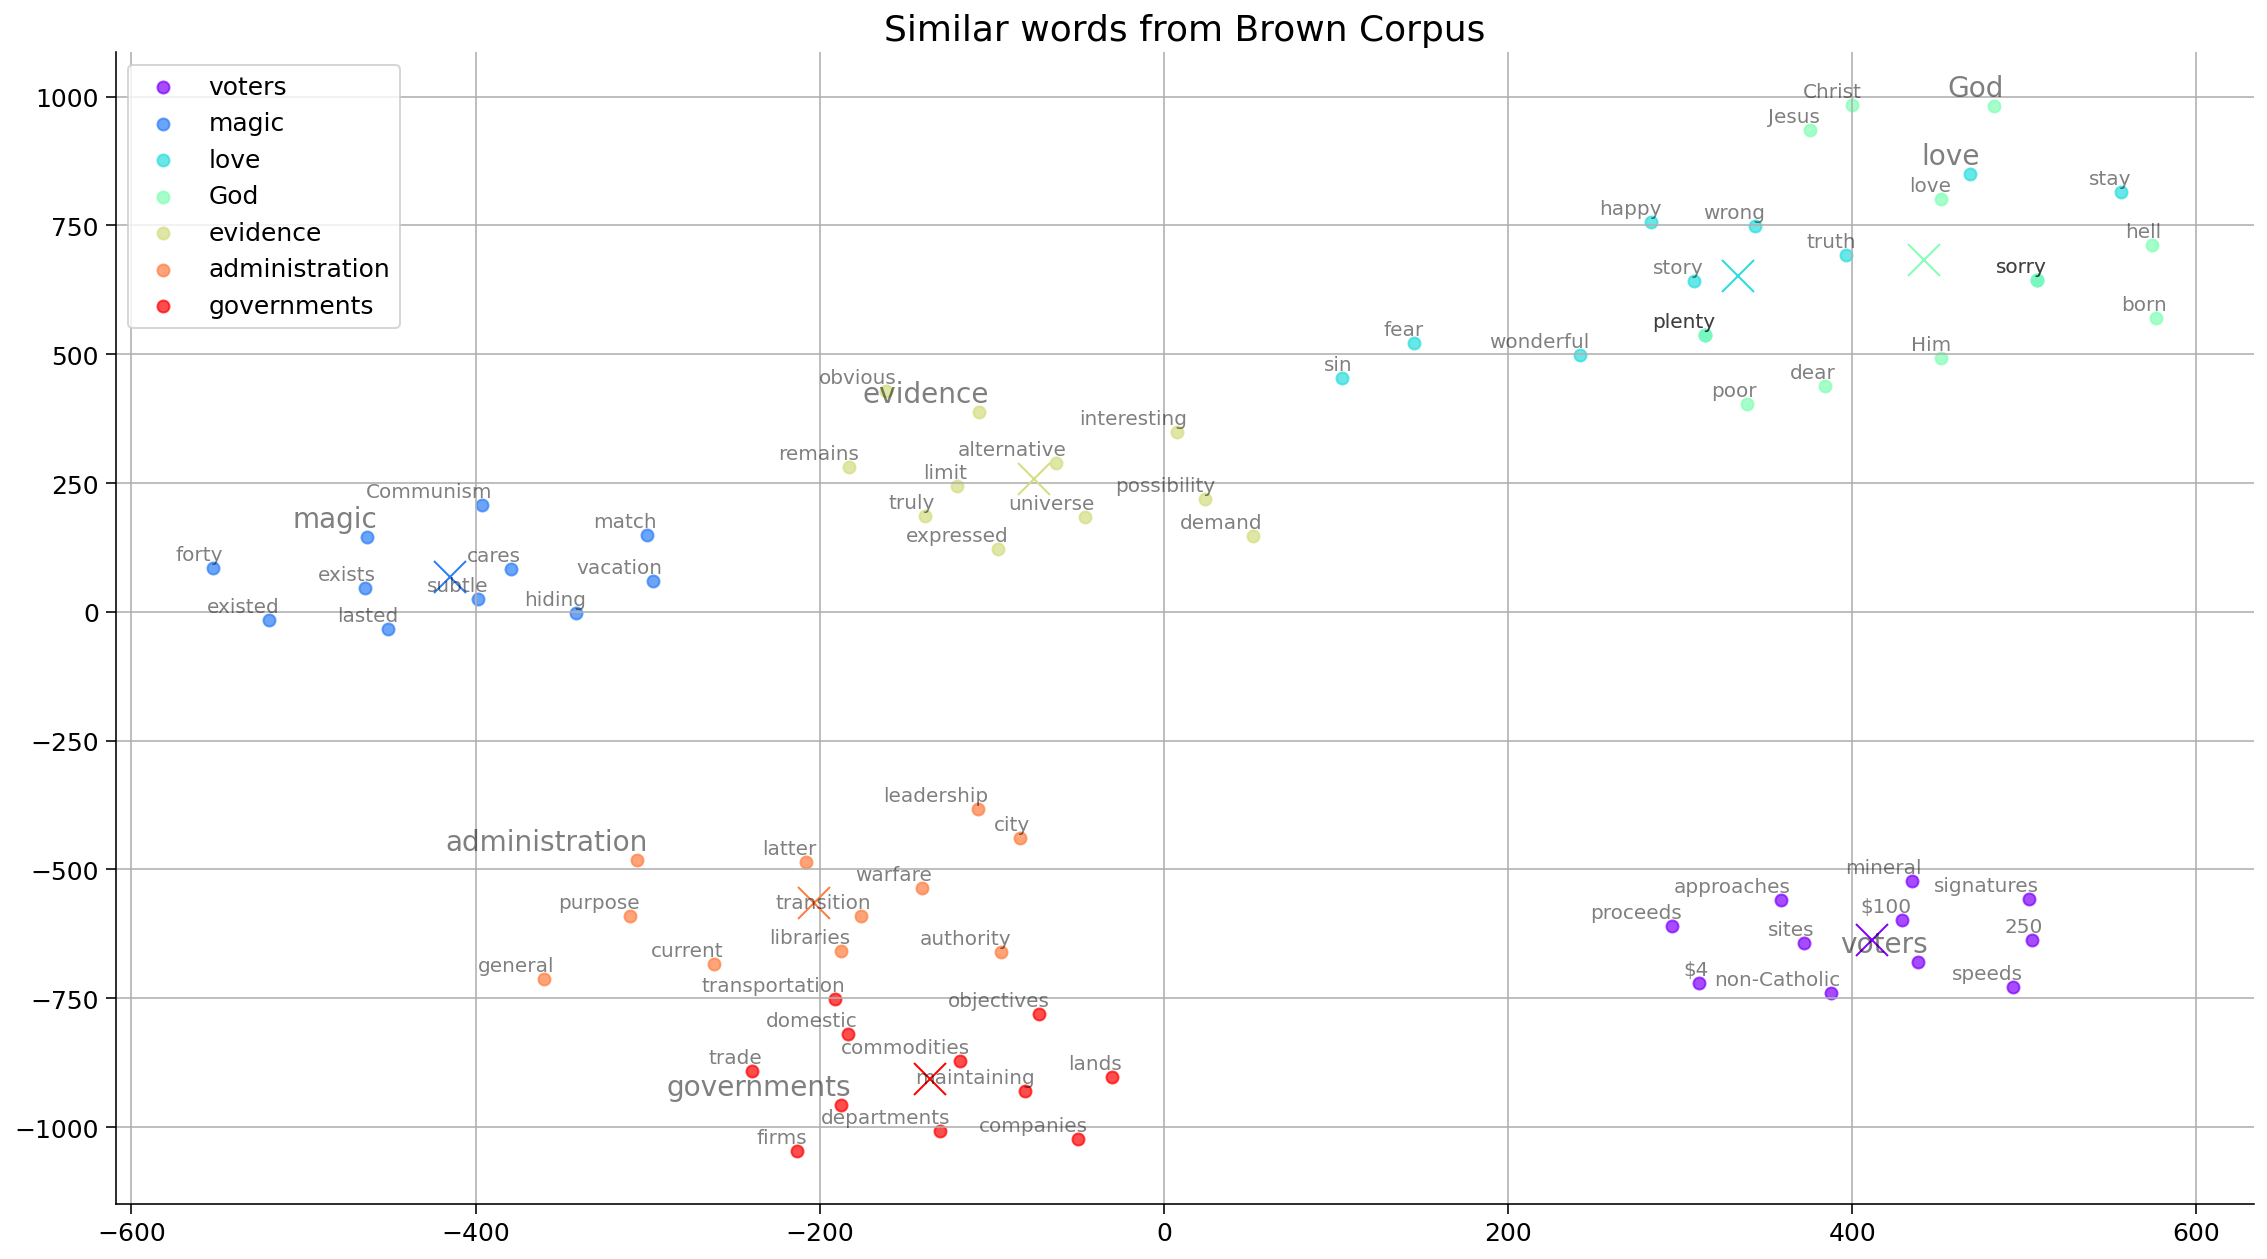

In [ ]:
# Get closest words to the keys and get clusters of these words
embeddings_en_2d, word_clusters = get_cluster_embeddings(keys)
# tSNE plot of similar words to keys
tsne_plot_similar_words(title='Similar words from Brown Corpus',
                        labels=keys,
                        embedding_clusters=embeddings_en_2d,
                        word_clusters=word_clusters,
                        opacity=0.7,
                        filename='similar_words.png')

### Think! 2.1

1. What does having higher similarity between two word embeddings mean?
2. Why are cluster centroids (represented with X in the plot) close to some keys (represented with larger fonts) but farther from others?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W2D5_TimeSeriesAndNaturalLanguageProcessing/solutions/W2D5_Tutorial1_Solution_61e9bed5.py)



In [ ]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

## Section 2.2: Embedding exploration

In [ ]:
# @title Video 4: NLP tokenization
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="GLreyXm4rg8", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
#atform.add_event('Video 4: NLP Tokenization')

display(out)

In [ ]:
# @title Video 5: Distributional Similarity
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="0vTuEIAnrII", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 5: Distributional Similarity')

display(out)

Words or subword units such as morphemes are the basic units we use to express meaning in language. The technique of mapping words to vectors of real numbers is known as word embedding.

In this section, we will use pretrained fastText embeddings, a context-oblivious embedding similar to word2vec.

### Embedding Manipulation

Let's use the [FastText](https://fasttext.cc/) library to manipulate the embeddings. First, find the embedding for the word "King"

In [ ]:
# @markdown ### Download FastText English Embeddings of dimension 100
# @markdown This will take 1-2 minutes to run

import os, zipfile, requests

url = "https://osf.io/2frqg/download"
fname = "cc.en.100.bin.gz"

print('Downloading Started...')
# Downloading the file by sending the request to the URL
r = requests.get(url, stream=True)

# Writing the file to the local file system
with open(fname, 'wb') as f:
  f.write(r.content)
print('Downloading Completed.')

# opening the zip file in READ mode
with zipfile.ZipFile(fname, 'r') as zipObj:
  # extracting all the files
  print('Extracting all the files now...')
  zipObj.extractall()
  print('Done!')
  os.remove(fname)

Extracting all the files now...
Done!


In [ ]:
# Load 100 dimension FastText Vectors using FastText library
ft_en_vectors = fasttext.load_model('cc.en.100.bin')
print(f"Length of the embedding is: {len(ft_en_vectors.get_word_vector('king'))}")
print(f"\nEmbedding for the word King is:\n {ft_en_vectors.get_word_vector('king')}")

Length of the embedding is: 100

Embedding for the word King is:
 [-0.04045481 -0.10617249 -0.27222311  0.06879666  0.16408321  0.00276707
  0.27080125 -0.05805573 -0.31865698  0.03748008 -0.00254088  0.13805169
 -0.00182498 -0.08973497  0.00319015 -0.19619396 -0.09858181 -0.10103802
 -0.08279888  0.0082208   0.13119364 -0.15956607  0.17203182  0.0315701
 -0.25064597  0.06182072  0.03929246  0.05157393  0.03543638  0.13660161
  0.05473648  0.06072914 -0.04709269  0.17394426 -0.02101276 -0.11402624
 -0.24489872 -0.08576579 -0.00322696 -0.04509873 -0.00614253 -0.05772085
 -0.073414   -0.06718913 -0.06057961  0.10963406  0.1245006  -0.04819863
  0.11408057  0.11081408  0.06752145 -0.01689911 -0.01186301 -0.11716368
 -0.01287614  0.10639337 -0.04243141  0.01057278 -0.0230855  -0.04930984
  0.04717607  0.03696446  0.0015999  -0.02193867 -0.01331578  0.11102925
  0.1686794   0.05814958 -0.00296521 -0.04252011 -0.00352389  0.06267346
 -0.07747819 -0.08959802 -0.02445797 -0.08913022  0.1342223

Cosine similarity is used for similarities between words. Similarity is a scalar between 0 and 1. Higher scalar value corresponds to higher similarity.

Now find the 10 most similar words to "king".

In [ ]:
ft_en_vectors.get_nearest_neighbors("king", 10)  # Most similar by key

[(0.8168574571609497, 'prince'),
 (0.796097457408905, 'emperor'),
 (0.7907207608222961, 'kings'),
 (0.7655220627784729, 'lord'),
 (0.7435404062271118, 'king-'),
 (0.7394551634788513, 'chieftain'),
 (0.7307553291320801, 'tyrant'),
 (0.7226710319519043, 'conqueror'),
 (0.719561755657196, 'kingly'),
 (0.718187689781189, 'queen')]

### Word Similarity

More on similarity between words. Let's check how similar different pairs of word are.

In [ ]:
def cosine_similarity(vec_a, vec_b):
  """Compute cosine similarity between vec_a and vec_b"""
  return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))


def getSimilarity(word1, word2):
  v1 = ft_en_vectors.get_word_vector(word1)
  v2 = ft_en_vectors.get_word_vector(word2)
  return cosine_similarity(v1, v2)


print(f"Similarity between the words King and Queen: {getSimilarity('king', 'queen')}")
print(f"Similarity between the words King and Knight: {getSimilarity('king', 'knight')}")
print(f"Similarity between the words King and Rock: {getSimilarity('king', 'rock')}")
print(f"Similarity between the words King and Twenty: {getSimilarity('king', 'twenty')}")

print(f"\nSimilarity between the words Dog and Cat: {getSimilarity('dog', 'cat')}")
print(f"Similarity between the words Ascending and Descending: {getSimilarity('ascending', 'descending')}")
print(f"Similarity between the words Victory and Defeat: {getSimilarity('victory', 'defeat')}")
print(f"Similarity between the words Less and More: {getSimilarity('less', 'more')}")
print(f"Similarity between the words True and False: {getSimilarity('true', 'false')}")

Similarity between the words King and Queen: 0.7181877493858337
Similarity between the words King and Knight: 0.6881008744239807
Similarity between the words King and Rock: 0.2892838716506958
Similarity between the words King and Twenty: 0.19655467569828033

Similarity between the words Dog and Cat: 0.833964467048645
Similarity between the words Ascending and Descending: 0.8707448840141296
Similarity between the words Victory and Defeat: 0.7478055953979492
Similarity between the words Less and More: 0.8461978435516357
Similarity between the words True and False: 0.595384955406189


In [ ]:
# @title Interactive Demo 2.2.1

# @markdown Check similarity between words

word1 = 'King'  # @param \ {type:"string"}
word2 = 'frog'  # @param \ {type:"string"}
word_similarity = getSimilarity(word1, word2)
print(f'Similarity between {word1} and {word2}: {word_similarity}')

Similarity between King and frog: 0.17687426507472992


Using embeddings, we can find the words that appear in similar contexts. But, what happens if the word has several different meanings? 

### Homonym Similarity

Homonyms are words that have the same spelling or pronunciation but different meanings depending on the context. Let's explore how these words are embedded and their similarity in different contexts.

In [ ]:
#######################     Words with multiple meanings     ##########################
print(f"Similarity between the words Cricket and Insect: {getSimilarity('cricket', 'insect')}")
print(f"Similarity between the words Cricket and Sport: {getSimilarity('cricket', 'sport')}")

Similarity between the words Cricket and Insect: 0.4072215259075165
Similarity between the words Cricket and Sport: 0.5812374353408813


In [ ]:
# @title Interactive Demo 2.2.2

# @markdown Explore homonyms \\

# @markdown examples - minute (time/small), pie (graph/food)

word = 'pie'  # @param \ {type:"string"}
context_word_1 = 'graph'  # @param \ {type:"string"}
context_word_2 = 'food'  # @param \ {type:"string"}
word_similarity_1 = getSimilarity(word, context_word_1)
word_similarity_2 = getSimilarity(word, context_word_2)
print(f'Similarity between {word} and {context_word_1}: {word_similarity_1}')
print(f'Similarity between {word} and {context_word_2}: {word_similarity_2}')

Similarity between pie and graph: 0.3573547899723053
Similarity between pie and food: 0.5135061740875244


### Word Analogies

Embeddings can be used to find word analogies.
Let's try it:
1.   Man : Woman  ::  King : _____
2.  Germany: Berlin :: France : _____
3.  Leaf : Tree  ::  Petal : _____





In [ ]:
## Use get_analogies() funnction.
# The words have to be in the order Positive, negative,  Positve

# Man : Woman  ::  King : _____
# Positive=(woman, king), Negative=(man)
print(ft_en_vectors.get_analogies("woman", "man", "king", 1))

# Germany: Berlin :: France : ______
# Positive=(berlin, frannce), Negative=(germany)
print(ft_en_vectors.get_analogies("berlin", "germany", "france", 1))

# Leaf : Tree  ::  Petal : _____
# Positive=(tree, petal), Negative=(leaf)
print(ft_en_vectors.get_analogies("tree", "leaf", "petal", 1))

[(0.8162637948989868, 'queen')]
[(0.8568049669265747, 'paris')]
[(0.7037209272384644, 'flower')]


But, does it always work?


1.   Poverty : Wealth  :: Sickness : _____
2.   train : board :: horse : _____

In [ ]:
# Poverty : Wealth  :: Sickness : _____
print(ft_en_vectors.get_analogies("wealth", "poverty", "sickness", 1))

# train : board :: horse : _____
print(ft_en_vectors.get_analogies("board", "train", "horse", 1))

[(0.615874171257019, 'affliction')]
[(0.5437814593315125, 'bull')]


## Section 2.3: Neural Net with word embeddings

In [ ]:
# @title Video 6: Using Embeddings
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="9ujUgNoPeF0", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# Add event to airtable
atform.add_event('Video 6: Using Embeddings')

display(out)

Training context-oblivious word embeddings is relatively cheap, but most people still use pre-trained word embeddings. After we cover context-sensitive word embeddings, we'll see how to "fine tune" embeddings (adjust them to the task at hand).

Let's use the pretrained FastText embeddings to train a neural network on the IMDB dataset.

The data consists of reviews and sentiments attached to it, and it is a binary classification task.

###  Coding Exercise 1: Simple feed forward net

Define a vanilla neural network with linear layers. Then average the word embeddings to get an embedding for the entire review. The neural net will have one hidden layer of size 128.

In [ ]:
class NeuralNet(nn.Module):
  """ A vanilla neural network. """
  def __init__(self, batch_size, output_size, hidden_size, vocab_size,
               embedding_length, word_embeddings):
    """
    Constructs a vanilla Neural Network Instance.

    Args:
      batch_size: Integer
        Specifies probability of dropout hyperparameter
      output_size: Integer
        Specifies the size of output vector
      hidden_size: Integer
        Specifies the size of hidden layer
      vocab_size: Integer
        Specifies the size of the vocabulary
        i.e. the number of tokens in the vocabulary
      embedding_length: Integer
        Specifies the size of the embedding vector
      word_embeddings
        Specifies the weights to create embeddings from
        voabulary.

    Returns:
      Nothing
    """
    super(NeuralNet, self).__init__()

    self.batch_size = batch_size
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embedding_length = embedding_length

    self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
    self.word_embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
    self.fc1 = nn.Linear(embedding_length, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, inputs):
    """
    Compute the final labels by taking tokens as input.

    Args:
      inputs: Tensor
        Tensor of tokens in the text

    Returns:
      out: Tensor
        Final prediction Tensor
    """
    input = self.word_embeddings(inputs)  # convert text to embeddings
    #################################################
    # Implement a vanilla neural network
    # raise NotImplementedError("Neural Net `forward`")
    #################################################
    # Average the word embedddings in a sentence
    # Use torch.nn.functional.avg_pool2d to compute the averages
    pooled = F.avg_pool2d(input, (input.shape[1], 1)).squeeze(1)
    # Pass the embeddings through the neural net
    # Use ReLU as the non-linearity
    x = self.fc1(pooled)
    x = F.relu(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output


# add event to airtable
atform.add_event('Coding Exercise 1: Neural Net for text classification')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W2D5_TimeSeriesAndNaturalLanguageProcessing/solutions/W2D5_Tutorial1_Solution_e152469f.py)



In [ ]:
# @markdown ### Helper functions

# @markdown - `train(model, device, train_iter, valid_iter, epochs, learning_rate)`

# @markdown - `test(model,  device, test_iter)`

# @markdown - `load_dataset(emb_vectors, seed, sentence_length=50, batch_size=32)`

# @markdown - `plot_train_val(x, train, val, train_label, val_label, title)`


# Training
def train(model, device, train_iter, valid_iter, epochs, learning_rate):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  for epoch in range(epochs):
    # train
    model.train()
    running_loss = 0.
    correct, total = 0, 0
    steps = 0

    for idx, batch in enumerate(train_iter):
      text = batch.text[0]
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      # add micro for coding training loop
      optimizer.zero_grad()
      output = model(text)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      steps += 1
      running_loss += loss.item()

      # get accuracy
      _, predicted = torch.max(output, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()
    train_loss.append(running_loss/len(train_iter))
    train_acc.append(correct/total)

    print(f'Epoch: {epoch + 1},  Training Loss: {running_loss/len(train_iter):.4f}, Training Accuracy: {100*correct/total: .2f}%')

    # evaluate on validation data
    model.eval()
    running_loss = 0.
    correct, total = 0, 0

    with torch.no_grad():
      for idx, batch in enumerate(valid_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(text)

        loss = criterion(output, target)
        running_loss += loss.item()

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    validation_loss.append(running_loss/len(valid_iter))
    validation_acc.append(correct/total)

    print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, Validation Accuracy: {100*correct/total: .2f}% \n')

  return train_loss, train_acc, validation_loss, validation_acc


# Testing
def test(model, device, test_iter):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(test_iter):
      text = batch.text[0]
      target = batch.label
      target = torch.autograd.Variable(target).long()
      text, target = text.to(device), target.to(device)

      outputs = model(text)
      _, predicted = torch.max(outputs, 1)
      total += target.size(0)
      correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc


def download_osf():
  # Download IMDB dataset from OSF
  import tarfile, requests, os
  url = "https://osf.io/dvse9/download"
  fname = "aclImdb_v1.tar.gz"

  print('Downloading Started...')
  # Downloading the file by sending the request to the URL
  r = requests.get(url, stream=True)

  # Writing the file to the local file system
  with open(fname, 'wb') as f:
    f.write(r.content)
  print('Downloading Completed.')

  with tarfile.open(fname) as f:
    # extracting all the files
    print('Extracting all the files now...')
    f.extractall('.data/imdb')  # specify which folder to extract to
    print('Done!')
    os.remove(fname)


def load_dataset(emb_vectors, seed, sentence_length=50, batch_size=32):
  download_osf()
  print("Dataset loading...")
  TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True,
                    include_lengths=True, batch_first=True,
                    fix_length=sentence_length)
  LABEL = data.LabelField(dtype=torch.float)

  train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

  TEXT.build_vocab(train_data, vectors=emb_vectors)
  LABEL.build_vocab(train_data)

  train_data, valid_data = train_data.split(split_ratio=0.7,
                                            random_state=random.seed(seed))
  datasets_ = (train_data, valid_data, test_data)
  train_iter, valid_iter, test_iter = data.BucketIterator.splits(datasets_,
                                                                 batch_size=batch_size,
                                                                 sort_key=lambda x: len(x.text),
                                                                 repeat=False,
                                                                 shuffle=True)
  vocab_size = len(TEXT.vocab)
  print("Done!")
  return TEXT, vocab_size, train_iter, valid_iter, test_iter


# Plotting
def plot_train_val(x, train, val, train_label, val_label, title):
  plt.plot(x, train, label=train_label)
  plt.plot(x, val, label=val_label)
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title(title)
  plt.show()


# Dataset
def tokenize(sentences):
  # Tokenize the sentence
  # from nltk.tokenize library use word_tokenize
  token = word_tokenize(sentences)
  return token

In [ ]:
# @markdown ### Download embeddings and load the dataset

# @markdown This will load 300 dim FastText embeddings.

# @markdown It will take around 3-4 minutes.

embedding_fasttext = FastText('simple')
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(embedding_fasttext, seed=SEED)

.vector_cache/wiki.simple.vec: 293MB [00:08, 33.4MB/s]                           
100%|██████████| 111051/111051 [00:09<00:00, 11156.63it/s]


Extracting all the files now...
Done!
Dataset loading...
Done!


In [ ]:
learning_rate = 0.0003
batch_size = 32
output_size = 2
hidden_size = 128
embedding_length = 300
epochs = 15
word_embeddings = TEXT.vocab.vectors
vocab_size = len(TEXT.vocab)

nn_model = NeuralNet(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
nn_model.to(DEVICE)
nn_start_time = time.time()
nn_train_loss, nn_train_acc, nn_validation_loss, nn_validation_acc = train(nn_model, DEVICE, train_iter, valid_iter, epochs, learning_rate)
print()
print(f"--- Time taken to train = {time.time() - nn_start_time} seconds ---")
test_accuracy = test(nn_model, DEVICE, test_iter)
print()
print(f'Test Accuracy: {test_accuracy}%')

Epoch: 1,  Training Loss: 0.6675, Training Accuracy:  60.66%
Validation Loss: 0.6430, Validation Accuracy:  64.09% 

Epoch: 2,  Training Loss: 0.6291, Training Accuracy:  65.29%
Validation Loss: 0.6116, Validation Accuracy:  67.77% 

Epoch: 3,  Training Loss: 0.6045, Training Accuracy:  67.77%
Validation Loss: 0.5929, Validation Accuracy:  69.24% 

Epoch: 4,  Training Loss: 0.5920, Training Accuracy:  69.13%
Validation Loss: 0.5866, Validation Accuracy:  69.23% 

Epoch: 5,  Training Loss: 0.5858, Training Accuracy:  69.17%
Validation Loss: 0.5803, Validation Accuracy:  69.41% 

Epoch: 6,  Training Loss: 0.5809, Training Accuracy:  69.67%
Validation Loss: 0.5777, Validation Accuracy:  69.47% 

Epoch: 7,  Training Loss: 0.5780, Training Accuracy:  69.87%
Validation Loss: 0.5757, Validation Accuracy:  69.64% 

Epoch: 8,  Training Loss: 0.5761, Training Accuracy:  69.97%
Validation Loss: 0.5825, Validation Accuracy:  69.52% 

Epoch: 9,  Training Loss: 0.5744, Training Accuracy:  70.19%
Val

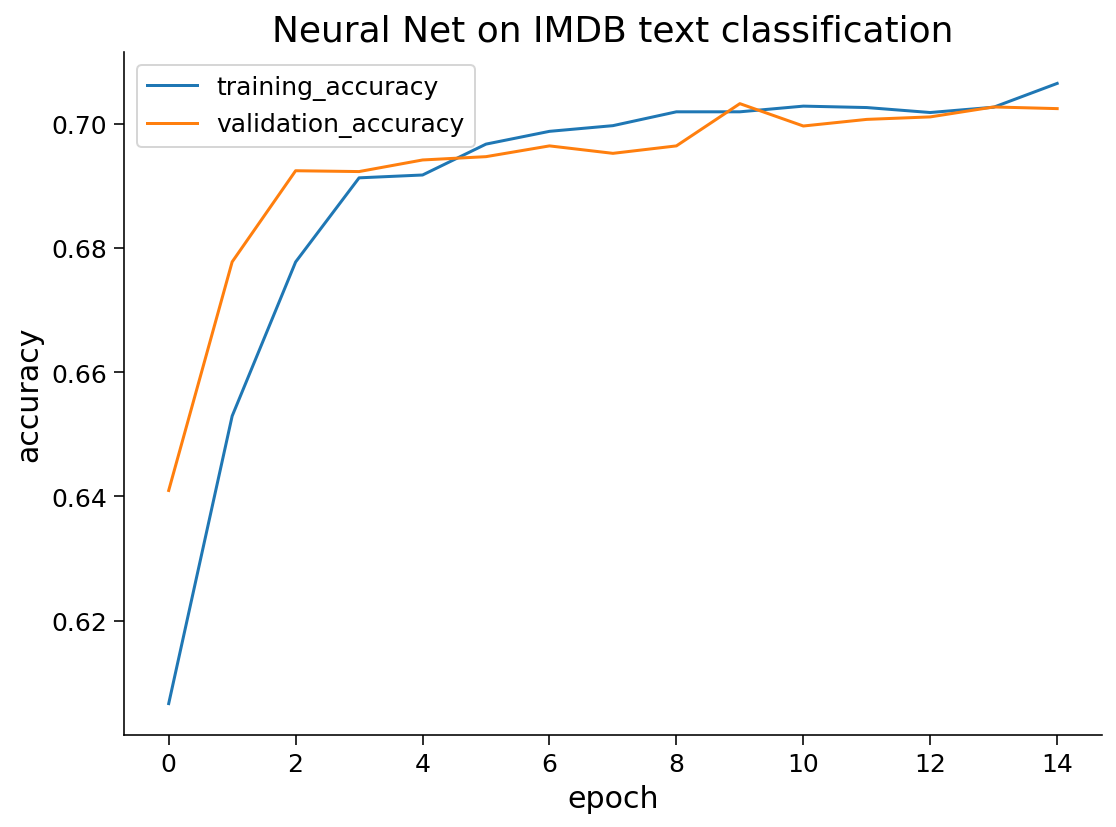

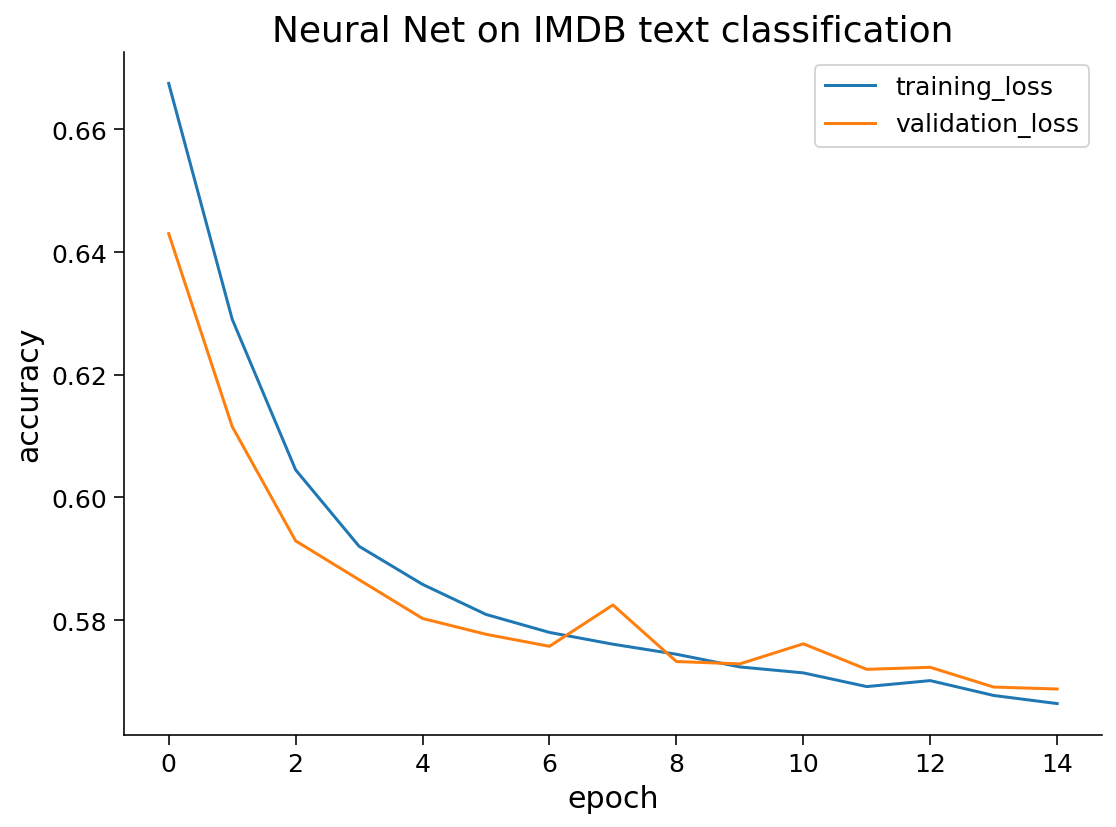

In [ ]:
plot_train_val(np.arange(0, epochs), nn_train_acc, nn_validation_acc,
               'training_accuracy', 'validation_accuracy',
               'Neural Net on IMDB text classification')
plot_train_val(np.arange(0, epochs), nn_train_loss, nn_validation_loss,
               'training_loss', 'validation_loss',
               'Neural Net on IMDB text classification')

---
# Summary

In this tutorial, we introduced how to process time series by taking language as an example. To process time series, we should convert them into embeddings.

We can first tokenize the words for text and then create either context-oblivious or context-dependent embeddings.

Finally, we saw how these word embeddings could be processed for applications such as text classification.

In [ ]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/AirtableSubmissionButton.png?raw=1"
 alt="button link to Airtable" style="width:410px"></a>
   </div>""" )

If you want to learn about **Multilingual Embeddings** see the Bonus tutorial on [colab](https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/tutorials/W2D5_TimeSeriesAndNaturalLanguageProcessing/W2D5_Tutorial3.ipynb) or [kaggle](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D5_TimeSeriesAndNaturalLanguageProcessing/W2D5_Tutorial3.ipynb). But first, we suggest completing the tutorial 2!